In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
from dataset import *
from model import ResNet18
from unlearn import *
from metrics import UnLearningScore
from utils import *
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision.models import resnet18
from torchvision.datasets import CIFAR100
from torch.nn import functional as F
from torch.nn.functional import softmax, log_softmax, kl_div
from sklearn.model_selection import train_test_split

In [2]:
num_workers = 8
batch_size = 64

In [189]:
transform_custom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 255.).to(torch.float32)),
])
class CustomCIFAR100(Dataset):
    def __init__(self, root, train, download, transform):
        self.dataset = CIFAR100(root=root, train=train, download=download, transform=transform)
        self.coarse_map = {
            0:[4, 30, 55, 72, 95],
            1:[1, 32, 67, 73, 91],
            2:[54, 62, 70, 82, 92],
            3:[9, 10, 16, 28, 61],
            4:[0, 51, 53, 57, 83],
            5:[22, 39, 40, 86, 87],
            6:[5, 20, 25, 84, 94],
            7:[6, 7, 14, 18, 24],
            8:[3, 42, 43, 88, 97],
            9:[12, 17, 37, 68, 76]
        }
        self.indices = [i for i, (_, target) in enumerate(self.dataset) if target in sum(self.coarse_map.values(), [])]
        
    def __getitem__(self, index):
        img, label = self.dataset[self.indices[index]]
        for clabel, labels in self.coarse_map.items():
            if label in labels:
                return img, label, clabel

    def __len__(self):
        return len(self.indices)

# Usage
train_ds = CustomCIFAR100(root='.', train=True, download=True, transform=transform_custom)
# train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_ds = CustomCIFAR100(root='.', train=False, download=True, transform=transform_custom)
# test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

100%|██████████| 169001437/169001437 [00:18<00:00, 9337098.35it/s] 


Extracting ./cifar-100-python.tar.gz to .
Files already downloaded and verified


In [4]:
forget_classes = [86]
sub_classes = [4, 30,               # 55, 72, 95,
              1,                    # 32, 67, 73, 91,
              54, 62,               # 70, 82, 92,
              9, 10,                # 16, 28, 61,
              0,                    # 51, 53, 57, 83,
              22, 39, 40, 86, 87,
              5, 20,                # 25, 84, 94,
              6,                    # 7, 14, 18, 24,
              3, 42,                # 43, 88, 97,
              12, 17,               # 37, 68, 76
              ]
# train
classwise_train = {}
for i in sub_classes:
    classwise_train[i] = []
for img, label, clabel in train_ds:
    if label in sub_classes:
        classwise_train[label].append((img, label, clabel))

# get retain_train set
retain_train = []
for cls in sub_classes:
    if cls not in forget_classes:
        retain_train += classwise_train[cls]

# get forget_train set
forget_train = []
forget_train += classwise_train[forget_classes[0]]

full_train_ds = retain_train + forget_train

# get test set (contain both retain and forget)
test_set = []
for img, label, clabel in test_ds:
    if label in sub_classes:
        test_set.append((img, label, clabel))

In [5]:
class_weights = [2., 1., 2., 2., 1., 5., 2., 1., 2., 2.]
class_weights_sample = [i*500 for i in class_weights]
class_weights_inv = [sum(class_weights) / (len(class_weights) * i) for i in class_weights]

In [6]:
print(len(retain_train), len(forget_train), len(test_set), len(full_train_ds))

9500 500 2000 10000


In [7]:
retain_train_dl = DataLoader(retain_train, batch_size=64, shuffle=True)
forget_train_dl = DataLoader(forget_train, batch_size=64, shuffle=True)
full_train_dl = DataLoader(full_train_ds, batch_size=64, shuffle=True)
test_set_dl = DataLoader(test_set, batch_size=64, shuffle=False)

In [8]:
class UnLearningData(Dataset):
    def __init__(self, forget_data, retain_data):
        super().__init__()
        self.forget_data = forget_data
        self.retain_data = retain_data
        self.forget_len = len(forget_data)
        self.retain_len = len(retain_data)

    def __len__(self):
        return self.retain_len + self.forget_len
    
    def __getitem__(self, index):
        if(index < self.forget_len):
            x = self.forget_data[index][0]
            hard_label = self.forget_data[index][2]
            y = 1
        else:
            x = self.retain_data[index - self.forget_len][0]
            hard_label = self.retain_data[index - self.forget_len][2]
            y = 0
        return x, hard_label, y

In [9]:
def get_dataset(retain_train_ds=retain_train, forget_train_ds=forget_train, batch_size=64, subset_ratio=0.3):
    
    hard_label = [item[2] for item in retain_train_ds]
    _, subset_idx = train_test_split(np.arange(len(hard_label)), 
                                    test_size=subset_ratio, stratify=hard_label)

    subset_retain_ds = Subset(retain_train_ds, list(subset_idx))
    
    retrain_data = UnLearningData(forget_data=[], retain_data=retain_train_ds)
    retrain_data_dl = DataLoader(retrain_data, batch_size=batch_size, shuffle=True)
    
    unlearning_data = UnLearningData(forget_data=forget_train_ds, retain_data=subset_retain_ds)
    unlearning_data_dl = DataLoader(unlearning_data, batch_size=batch_size, shuffle=True)
    return unlearning_data_dl, retrain_data_dl

# Forgetting class 68: Road
The Road is class 68 in CIFAR100 and belongs to Super Class 9 (large_man-made_outdoor_things) in CIFAR Super 20.

## UnLearning via proposed method

### Define unlearn loss and unlearning method

In [10]:
device = 'cuda'

In [143]:
def unlearn_loss(student_logits, label, smart_teacher_logits, dumb_teacher_logits, KL_temperature):
    label = torch.unsqueeze(label, dim = 1)
    
    s_teacher_out = softmax(smart_teacher_logits / KL_temperature, dim=1)
    d_teacher_out = softmax(dumb_teacher_logits / KL_temperature, dim=1)

    # label 1 means forget sample
    # label 0 means retain sample
    overall_teacher_out = label * d_teacher_out + (1 - label) * s_teacher_out
    student_out = log_softmax(student_logits / KL_temperature, dim=1)
    return kl_div(student_out, overall_teacher_out)


def unlearning_func(student_model, smart_teacher, dumb_teacher, 
                    unlearning_data_dl,
                    epochs, learning_rate, KL_temperature=1,
                    optim='adam',
                    DEVICE=device):
    if optim == 'adam':
        optimizer = torch.optim.Adam(student_model.parameters(), lr = learning_rate)
    else:
        optimizer = torch.optim.SGD(student_model.parameters(), lr=learning_rate, 
                                    momentum=0.9, weight_decay=5e-4)
    student_model.train()
    for _ in range(epochs):
        student_model.train()
        for x, _, y in unlearning_data_dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            with torch.no_grad():
                smart_teacher_logits = smart_teacher(x)
                dumb_teacher_logits = dumb_teacher(x)
            student_logits = student_model(x)
            optimizer.zero_grad()
            loss = unlearn_loss(student_logits=student_logits, label=y,
                                smart_teacher_logits=smart_teacher_logits,
                                dumb_teacher_logits=dumb_teacher_logits,
                                KL_temperature=KL_temperature)
            loss.backward()
            optimizer.step()
    student_model.eval()
    return student_model

### Retrain model from scratch

In [175]:
def retrain_from_scratch(retrain_data_dl, epochs, class_weights, learning_rate, optim):
    dumb_teacher = resnet18(weights=None, num_classes=10).to(device)
    # using age_class_weights.json
    if class_weights != None:
        class_weights = torch.tensor(class_weights)
        class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
    if optim == 'adam':
        optimizer = torch.optim.Adam(dumb_teacher.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(dumb_teacher.parameters(), lr=learning_rate, 
                                    momentum=0.9, weight_decay=5e-4)
    dumb_teacher.train()
    for _ in range(epochs):
        dumb_teacher.train()
        for x, hard_label, y in retrain_data_dl:
            x, hard_label = x.to(device), hard_label.to(device)
            optimizer.zero_grad()
            output = dumb_teacher(x)
            loss = criterion(output, hard_label)
            loss.backward()
            optimizer.step()
    dumb_teacher.eval()
    return dumb_teacher

### Train original model and gold  (This block code has done. Do not need to run again!)

In [23]:
# train the Original_Model
original_model = ResNet18(num_classes = 10, pretrained = True).to(device)
# original_model.load_state_dict(torch.load('Original_Model_trained_10_classes.pt'))
history = fit_one_cycle(epochs=5, model=original_model, train_loader=full_train_dl, val_loader=test_set_dl,
                        pretrained_lr=1e-4, finetune_lr=1e-4, device='cuda')
print(evaluate(original_model, forget_train_dl, device='cuda'), '\n', 
      evaluate(original_model, retain_train_dl, device='cuda'), '\n',
      evaluate(original_model, test_set_dl, device='cuda'))

Epoch [0], last_lr: 0.00010, train_loss: 1.1605, val_loss: 0.7260, val_acc: 74.3652
Epoch [1], last_lr: 0.00010, train_loss: 0.5621, val_loss: 0.6538, val_acc: 77.8320
Epoch [2], last_lr: 0.00010, train_loss: 0.3317, val_loss: 0.6340, val_acc: 78.6621
Epoch [3], last_lr: 0.00010, train_loss: 0.2082, val_loss: 0.6749, val_acc: 79.2969
Epoch [4], last_lr: 0.00010, train_loss: 0.1455, val_loss: 0.6800, val_acc: 80.1758
{'Loss': 0.0204707533121109, 'Acc': 99.36898803710938} 
 {'Loss': 0.03597160428762436, 'Acc': 99.31837463378906} 
 {'Loss': 0.6800447702407837, 'Acc': 80.17578125}


In [24]:
gold_model = ResNet18(num_classes = 10, pretrained = True).to(device)
history = fit_one_cycle(epochs=5, model=gold_model, train_loader=retain_train_dl, val_loader=test_set_dl,
                        pretrained_lr=1e-4, finetune_lr=1e-4, device='cuda')
print(evaluate(gold_model, forget_train_dl, device='cuda'), '\n', 
      evaluate(gold_model, retain_train_dl, device='cuda'), '\n',
      evaluate(gold_model, test_set_dl, device='cuda'))

Epoch [0], last_lr: 0.00010, train_loss: 1.2287, val_loss: 0.7613, val_acc: 73.7793
Epoch [1], last_lr: 0.00010, train_loss: 0.5805, val_loss: 0.6285, val_acc: 78.1250
Epoch [2], last_lr: 0.00010, train_loss: 0.3414, val_loss: 0.6335, val_acc: 78.5645
Epoch [3], last_lr: 0.00010, train_loss: 0.1996, val_loss: 0.6561, val_acc: 79.1016
Epoch [4], last_lr: 0.00010, train_loss: 0.1412, val_loss: 0.6759, val_acc: 79.2480
{'Loss': 0.5875015258789062, 'Acc': 83.14302825927734} 
 {'Loss': 0.031898993998765945, 'Acc': 99.4651870727539} 
 {'Loss': 0.6759098768234253, 'Acc': 79.248046875}


In [ ]:
original_model.eval(); gold_model.eval()

In [26]:
torch.save(original_model.state_dict(), "Original_Model.pt")
torch.save(gold_model.state_dict(), "Gold_Model.pt")

### Metrics of Kaggle competitions

In [13]:
from sklearn.metrics import make_scorer
from sklearn import linear_model, model_selection
from copy import deepcopy
from typing import Callable
from tqdm.notebook import tqdm

In [14]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, _, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total

def compute_outputs(net, loader):
    """Auxiliary function to compute the logits for all datapoints.
    Does not shuffle the data, regardless of the loader.
    """
    # Make sure loader does not shuffle the data
    if isinstance(loader.sampler, torch.utils.data.sampler.RandomSampler):
        loader = DataLoader(
            loader.dataset, 
            batch_size=loader.batch_size, 
            shuffle=False, 
            num_workers=loader.num_workers)
    
    all_outputs = []
    for inputs, _, _ in loader:
        inputs = inputs.to(device)
        logits = net(inputs).detach().cpu().numpy() # (batch_size, num_classes)
        all_outputs.append(logits)
        
    return np.concatenate(all_outputs) # (len(loader.dataset), num_classes)

def false_positive_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false positive rate (FPR)."""
    fp = np.sum(np.logical_and((y_pred == 1), (y_true == 0)))
    n = np.sum(y_true == 0)
    return fp / n

def false_negative_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false negative rate (FNR)."""
    fn = np.sum(np.logical_and((y_pred == 0), (y_true == 1)))
    p = np.sum(y_true == 1)
    return fn / p

# The SCORING dictionary is used by sklearn's `cross_validate` function so that
# we record the FPR and FNR metrics of interest when doing cross validation
SCORING = {
    'false_positive_rate': make_scorer(false_positive_rate),
    'false_negative_rate': make_scorer(false_negative_rate)
}

In [15]:
def cross_entropy_f(x):
    # To ensure this function doesn't fail due to nans, find all-nan rows in x and substitude them with all-zeros.
    x[np.all(np.isnan(x), axis=-1)] = np.zeros(x.shape[-1])
    pred = torch.tensor(np.nanargmax(x, axis = -1))
    x = torch.tensor(x)
    fn = nn.CrossEntropyLoss(reduction="none")
    return fn(x, pred).numpy()

In [16]:
def logistic_regression_attack(
        outputs_U, outputs_R, n_splits=2, random_state=0):
    """Computes cross-validation score of a membership inference attack.
    Args:
      outputs_U: numpy array of shape (N)
      outputs_R: numpy array of shape (N)
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      fpr, fnr : float * float
    """
    assert len(outputs_U) == len(outputs_R)
    
    samples = np.concatenate((outputs_R, outputs_U)).reshape((-1, 1))
    labels = np.array([0] * len(outputs_R) + [1] * len(outputs_U))

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    scores =  model_selection.cross_validate(
        attack_model, samples, labels, cv=cv, scoring=SCORING)
    
    fpr = np.mean(scores["test_false_positive_rate"])
    fnr = np.mean(scores["test_false_negative_rate"])
    
    return fpr, fnr


def best_threshold_attack(
        outputs_U: np.ndarray, 
        outputs_R: np.ndarray, 
        random_state: int = 0
    ) -> tuple[list[float], list[float]]:
    """Computes FPRs and FNRs for an attack that simply splits into 
    predicted positives and predited negatives based on any possible 
    single threshold.

    Args:
      outputs_U: numpy array of shape (N)
      outputs_R: numpy array of shape (N)
    Returns:
      fpr, fnr : list[float] * list[float]
    """
    assert len(outputs_U) == len(outputs_R)
    
    samples = np.concatenate((outputs_R, outputs_U))
    labels = np.array([0] * len(outputs_R) + [1] * len(outputs_U))

    N = len(outputs_U)
    
    fprs, fnrs = [], []
    for thresh in sorted(list(samples.squeeze())):
        ypred = (samples > thresh).astype("int")
        fprs.append(false_positive_rate(labels, ypred))
        fnrs.append(false_negative_rate(labels, ypred))
    
    return fprs, fnrs

In [17]:
def compute_epsilon_s(fpr: list[float], fnr: list[float], delta: float) -> float:
    """Computes the privacy degree (epsilon) of a particular forget set example, 
    given the FPRs and FNRs resulting from various attacks.
    
    The smaller epsilon is, the better the unlearning is.
    
    Args:
      fpr: list[float] of length m = num attacks. The FPRs for a particular example. 
      fnr: list[float] of length m = num attacks. The FNRs for a particular example.
      delta: float
    Returns:
      epsilon: float corresponding to the privacy degree of the particular example.
    """
    assert len(fpr) == len(fnr)
    
    per_attack_epsilon = [0.]
    for fpr_i, fnr_i in zip(fpr, fnr):
        if fpr_i == 0 and fnr_i == 0:
            per_attack_epsilon.append(np.inf)
        elif fpr_i == 0 or fnr_i == 0:
            pass # discard attack
        else:
            with np.errstate(invalid='ignore'):
                epsilon1 = np.log(1. - delta - fpr_i) - np.log(fnr_i)
                epsilon2 = np.log(1. - delta - fnr_i) - np.log(fpr_i)
            if np.isnan(epsilon1) and np.isnan(epsilon2):
                per_attack_epsilon.append(np.inf)
            else:
                per_attack_epsilon.append(np.nanmax([epsilon1, epsilon2]))
            
    return np.nanmax(per_attack_epsilon)


def bin_index_fn(
        epsilons: np.ndarray, 
        bin_width: float = 0.5, 
        B: int = 13
        ) -> np.ndarray:
    """The bin index function."""
    bins = np.arange(0, B) * bin_width
    return np.digitize(epsilons, bins)


def F(epsilons: np.ndarray) -> float:
    """Computes the forgetting quality given the privacy degrees 
    of the forget set examples.
    """
    ns = bin_index_fn(epsilons)
    hs = 2. / 2 ** ns
    return np.mean(hs)

In [18]:
def forgetting_quality(
        outputs_U: np.ndarray, # (N, S)
        outputs_R: np.ndarray, # (N, S)
        attacks: list[Callable] = [best_threshold_attack, logistic_regression_attack],
        delta: float = 0.01
    ):
    """
    Both `outputs_U` and `outputs_R` are of numpy arrays of ndim 2:
    * 1st dimension coresponds to the number of samples obtained from the 
      distribution of each model (N=512 in the case of the competition's leaderboard) 
    * 2nd dimension corresponds to the number of samples in the forget set (S).
    """
    
    # N = number of model samples
    # S = number of forget samples
    N, S = outputs_U.shape
    
    assert outputs_U.shape == outputs_R.shape, \
        "unlearn and retrain outputs need to be of the same shape"
    
    epsilons = []
    pbar = tqdm(range(S))
    for sample_id in pbar:
        pbar.set_description("Computing F...")
        
        sample_fprs, sample_fnrs = [], []
        
        for attack in attacks: 
            uls = outputs_U[:, sample_id]
            rls = outputs_R[:, sample_id]
            
            fpr, fnr = attack(uls, rls)
            
            if isinstance(fpr, list):
                sample_fprs.extend(fpr)
                sample_fnrs.extend(fnr)
            else:
                sample_fprs.append(fpr)
                sample_fnrs.append(fnr)
        
        sample_epsilon = compute_epsilon_s(sample_fprs, sample_fnrs, delta=delta)
        epsilons.append(sample_epsilon)
        
    return F(np.array(epsilons))

In [176]:
def unlearn_method_1(original_model, net, subset_ratio, 
                     epochs_train_dumb, epochs_unlearn, lr_dumb, lr_unlearn, 
                     class_weights_dumb,
                     optim_dumb, optim_unlearn):
    unlearning_data_dl, retrain_data_dl = get_dataset(batch_size=batch_size, subset_ratio=subset_ratio)
    # retrain from scratch with remaining_data to obtain a dumb_teacher
    dumb_teacher = retrain_from_scratch(retrain_data_dl=retrain_data_dl, 
                                        epochs=epochs_train_dumb, class_weights=class_weights_dumb, learning_rate=lr_dumb,
                                        optim=optim_dumb)
    
    net.load_state_dict(torch.load("Original_Model.pt"))
    student_model = unlearning_func(student_model=net, smart_teacher=original_model, dumb_teacher=dumb_teacher,
                                    unlearning_data_dl=unlearning_data_dl,
                                    epochs=epochs_unlearn, learning_rate=lr_unlearn, KL_temperature=1,
                                    optim=optim_unlearn, 
                                    DEVICE=device)
    return student_model

In [178]:
def score_unlearning_algorithm(
        retain_loader, forget_loader, test_loader,
        original_model, gold_model,
        n: int = 10,
        delta: float = 0.01,
        f: Callable = cross_entropy_f,
        attacks: list[Callable] = [best_threshold_attack, logistic_regression_attack],
        epochs_train_dumb = 1, epochs_unlearn = 1,
        lr_dumb = 1e-3, lr_unlearn = 1e-4,
        subset_ratio = 0.3,
        class_weights_dumb = None,
        optim_dumb='adam', optim_unlearn='adam'
        ) -> dict:
    
    # n=512 in the case of unlearn and n=1 in the
    # case of retrain, since we are only provided with one retrained model here

    outputs_U = []
    RAU, TAU = [], []
    # forget_accuracy = []
    net = ResNet18(num_classes = 10, pretrained=False)
    net.to(device)

    pbar = tqdm(range(n))
    for _ in pbar:
        # unlearned model
        pbar.set_description(f"Unlearning...")
        
        student_model = unlearn_method_1(original_model, net, subset_ratio, epochs_train_dumb, epochs_unlearn, 
                                         lr_dumb, lr_unlearn, class_weights_dumb, optim_dumb=optim_dumb, optim_unlearn=optim_unlearn)
        # student_model = ResNet18(num_classes = 10, pretrained = False).to(device)
        # student_model.load_state_dict(torch.load('Gold_Model.pt'))
        # student_model.eval()

        outputs_Ui = compute_outputs(student_model, forget_loader)
        outputs_U.append(f(outputs_Ui))                             # forget quality

        RAU.append(accuracy(student_model, retain_loader))          # RAU
        TAU.append(accuracy(student_model, test_loader))            # TAU

    outputs_U = np.array(outputs_U) # (n, len(forget_loader.dataset))

    assert outputs_U.shape == (n, len(forget_loader.dataset)),\
        "Wrong shape for outputs_U. Should be (num_model_samples, num_forget_datapoints)."

    RAU = np.mean(RAU)
    TAU = np.mean(TAU)
    RAR = accuracy(gold_model, retain_loader)
    TAR = accuracy(gold_model, test_loader)

    RA_ratio = RAU / RAR
    TA_ratio = TAU / TAR
    print('RA_ratio:', RA_ratio, '. TA_ratio:', TA_ratio)
    
    scale = np.std(outputs_U) / 100.
    print('Scale:', scale)
    outputs_Ri = compute_outputs(gold_model, forget_loader) #(len(forget_loader.dataset), 10) 
    outputs_Ri = np.expand_dims(outputs_Ri, axis=0)
    outputs_Ri = np.random.normal(loc=outputs_Ri, scale=scale, size=(n, *outputs_Ri.shape[-2:]))
    
    outputs_R = np.array([ f( oRi ) for oRi in outputs_Ri ])
    f = forgetting_quality(outputs_U, 
                            outputs_R,
                            attacks=attacks,
                            delta=delta)

    return {
        "total_score": f * RA_ratio * TA_ratio,
        "forget quality": f,
        "unlearn_retain_accuracy": RAU,
        "unlearn_test_accuracy": TAU, 
        "retrain_retain_accuracy": RAR,
        "retrain_test_accuracy": TAR, 
    }

In [20]:
device = 'cuda'

original_model = ResNet18(num_classes = 10, pretrained = False).to(device)
original_model.load_state_dict(torch.load('Original_Model.pt'))
original_model = original_model.eval()

gold_model = ResNet18(num_classes = 10, pretrained = False).to(device)
gold_model.load_state_dict(torch.load('Gold_Model.pt'))
gold_model = gold_model.eval()

In [21]:
print(evaluate(original_model, forget_train_dl, device='cuda'), '\n', 
      evaluate(original_model, retain_train_dl, device='cuda'), '\n',
      evaluate(original_model, test_set_dl, device='cuda'))
print(evaluate(gold_model, forget_train_dl, device='cuda'), '\n', 
      evaluate(gold_model, retain_train_dl, device='cuda'), '\n',
      evaluate(gold_model, test_set_dl, device='cuda'))

{'Loss': 0.02024286612868309, 'Acc': 99.4140625} 
 {'Loss': 0.03589991107583046, 'Acc': 99.31837463378906} 
 {'Loss': 0.6800447702407837, 'Acc': 80.17578125}
{'Loss': 0.5820142030715942, 'Acc': 83.23316955566406} 
 {'Loss': 0.032113634049892426, 'Acc': 99.45170593261719} 
 {'Loss': 0.6759098768234253, 'Acc': 79.248046875}


In [ ]:
score_unlearning_algorithm(retain_loader=retain_train_dl,
                            forget_loader=forget_train_dl,
                            test_loader=test_set_dl,
                            original_model=original_model,
                            gold_model=gold_model,
                            n=16,
                            delta=0.01,
                            f = cross_entropy_f,
                            attacks = [best_threshold_attack, logistic_regression_attack],
                            epochs_train_dumb = 3, 
                            epochs_unlearn = 1,
                            lr_dumb = 1e-2,
                            lr_unlearn = 1e-3,
                            subset_ratio = 0.3,
                            class_weights_dumb=class_weights_sample,
                            optim_dumb='adam', optim_unlearn='SGD'
                           )

In [39]:
net = ResNet18(num_classes = 10, pretrained=False)
net.to(device)
student_model = unlearn_method_1(original_model, net, subset_ratio=0.2, epochs_train_dumb=3, epochs_unlearn=1, 
                                         lr_dumb=1e-3, lr_unlearn=1e-4, class_weights_dumb=class_weights_sample)

In [44]:
student_logits = compute_outputs(student_model, forget_train_dl)

In [60]:
oracle_logits = compute_outputs(gold_model, forget_train_dl)
original_logits = compute_outputs(original_model, forget_train_dl)

In [93]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

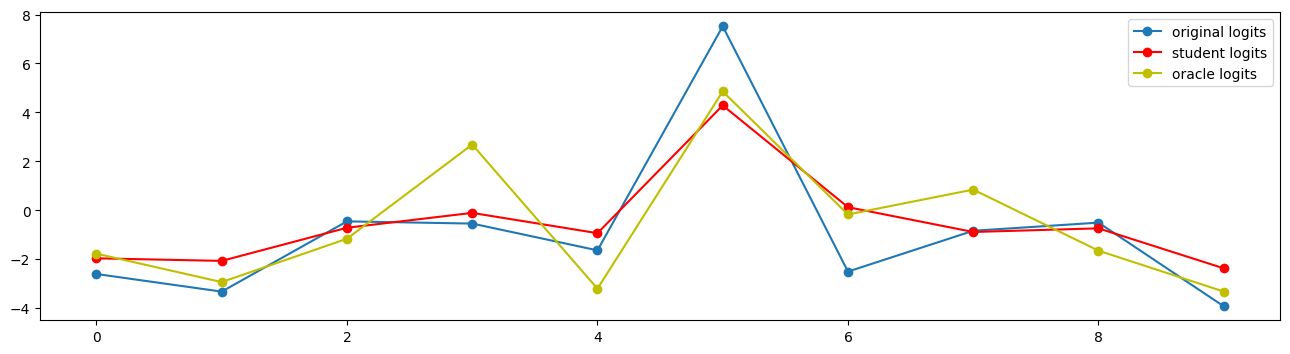

In [141]:
plt.figure(figsize=(16, 4))
plt.plot(original_logits.flatten()[:10], marker='o', label='original logits', c='C0')
plt.plot(student_logits.flatten()[:10], marker='o', label='student logits', c='r')
plt.plot(oracle_logits.flatten()[:10], marker='o', label='oracle logits', c='y')
plt.legend(); plt.show()

In [120]:
student_df = pd.DataFrame(student_logits)
original_df = pd.DataFrame(original_logits)
oracle_df = pd.DataFrame(oracle_logits)
student_df['type'] = 'student logits'
oracle_df['type'] = 'oracle logits'
original_df['type'] = 'original logits'
all_df = pd.concat([original_df, student_df, oracle_df], axis=0, ignore_index=True)
full_df = pd.DataFrame([])
for i in range(10):
    temp = all_df[[i, 'type']]
    temp.columns = ['value', 'type']
    temp['classes'] = f'{i}'
    full_df = pd.concat([full_df, temp], axis=0, ignore_index=True)
    
full_df

,value,type,classes
0,-2.615278,original logits,0
1,-1.844071,original logits,0
2,-1.768499,original logits,0
3,-2.965130,original logits,0
4,-1.857451,original logits,0
...,...,...,...
14995,-0.927618,oracle logits,9
14996,-0.549339,oracle logits,9
14997,-0.815304,oracle logits,9
14998,-3.375925,oracle logits,9


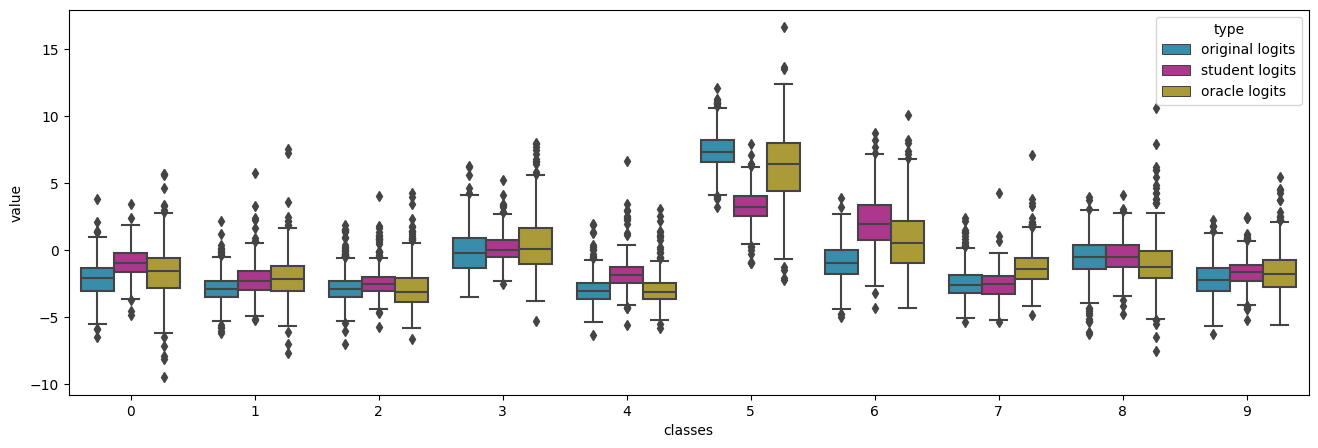

In [140]:
plt.figure(figsize=(16, 5))
sns.boxplot(data=full_df, x='classes', y='value', hue='type', palette=['#2596be', '#be2596', '#bea925'])
# plt.tight_layout()
plt.show()

In [142]:
class_weights

[2.0, 1.0, 2.0, 2.0, 1.0, 5.0, 2.0, 1.0, 2.0, 2.0]